# 1. Setup

In [9]:
import pickle
from time import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import plotly.express as px
import shap
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
# %%bash
# # t=0:07
# path=../data/nhts/2017
# mkdir -p $path; cd $path
# url="https://nhts.ornl.gov/assets/2016/download/csv.zip"
# wget $url
# unzip csv.zip

In [2]:
pd.read_csv('../data/nhts/trippub.csv', nrows=2)

HOUSEID  PERSONID  TDTRPNUM  ...  DBHTNRNT  DBPPOPDN  DBRESDN
0  30000007         1         1  ...        30       300      300
1  30000007         1         2  ...        20       750      300

[2 rows x 115 columns]

In [3]:
def get_trip_data():
    trip = pd.read_csv('../data/nhts/trippub.csv').rename(columns=str.lower)
    df = Pdf()
    def cut(col: str, bins: list[float], labels: list[str]) -> pd.Categorical:
        return pd.cut(trip[col], [-INF] + bins + [INF], True, labels)
    def classify(col: str, mapping: dict) -> pd.Categorical:
        cats = Series(list(mapping.values())).drop_duplicates().to_list()
        return pd.Categorical(trip[col].map(mapping), categories=cats)
    ## Deterrence measures
    df['Distance'] = trip['trpmiles'] * MI2M / 1000 # in km
    df['Duration'] = trip['trvlcmin'] # in minutes
    df['Speed'] = (df.Distance / (df.Duration / 60)) # in km/h
    for col, vmax in D(Distance=200, Duration=120, Speed=100).items():
        df.loc[(df[col] <= 0) | (df[col] > vmax), col] = np.nan
    df['LogDistance'] = np.log10(1 + df.Distance * 1000) # distance in meters
    # estimated gas price in $ assuming a constant mileage of 20 mi/ga
    # df['Cost'] = (trip['gasprice'] / 100) * (df.Distance * 1000 / MI2M) / 20
    df['TripWeight'] = normalize(trip['wttrdfin'])
    ## Trip attributes
    df['HomeBased'] = (trip['trippurp'] == 'NHB').map({False: 'yes', True: 'no'})
    df['Purpose'] = classify('whytrp90', {1: 'work', 2: 'work', 3: 'shopping',
                                          4: 'social', 5: 'school/church', 6: 'medical',
                                          8: 'social', 10: 'recreation'})
    df['Mode'] = classify('trptrans', {x: 'drive' for x in [3, 4, 5, 6, 17, 18]} | 
                                      {x: 'transit' for x in [10, 11, 12, 13, 14, 15, 16]} |
                                      {1: 'walk', 2: 'bike'})
    df['VehType'] = classify('vehtype', {1: 'car', 2: 'van', 3: 'suv', 4: 'pickup'} | 
                             {x: 'other' for x in [-1, 5, 6, 7]})
    df['Weekend'] = classify('tdwknd', {1: 'yes', 2: 'no'})
    df['Occupancy'] = cut('numontrp', [1, 2], ['single', 'pair', 'multiple'])
    df['GasPrice'] = cut('gasprice', [233, 267], ['low', 'mid', 'high'])
    df['StartTime'] = (pd.cut(trip['strttime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'off_peak', 'morn_peak', 'off_peak', 'eve_peak', 'off_peak'], ordered=False)
                       .cat.reorder_categories(['morn_peak', 'eve_peak', 'off_peak']))
    df['EndTime'] = (pd.cut(trip['endtime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'off_peak', 'morn_peak', 'off_peak', 'eve_peak', 'off_peak'], ordered=False)
                       .cat.reorder_categories(['morn_peak', 'eve_peak', 'off_peak']))
    df['StayTime'] = cut('dweltime', [5, 15, 60, 480], ['very_short', 'short', 'mid', 'long', 'very_long'])
    ## SES of respondent/household
    # df['Age'] = normalize(trip['r_age'].clip(0, 80))
    df['AgeGrp'] = cut('r_age', [0, 30, 64], ['n/a', 'young', 'mid', 'senior'])
    df['Sex'] = classify('r_sex', {1: 'male', 2: 'female'})
    df['Race'] = classify('hh_race', {1: 'white'} | {x: 'nonwhite' for x in [2, 3, 4, 5, 6]})
    df['Hispanic'] = classify('hh_hisp', {1: 'yes', 2: 'no'})
    df['Education'] = cut('educ', [0, 2], ['n/a', 'school', 'college'])
    df['Worker'] = classify('worker', {1: 'yes', 2: 'no'})
    df['Income'] = cut('hhfaminc', [0, 5, 7], ['n/a', 'low', 'mid', 'high'])
    df['HomeOwn'] = classify('homeown', {1: 'own', 2: 'rent'})
    ## Origin/destination attributes
    df['Region'] = cut('census_r', [1, 2, 3], ['northeast', 'midwest', 'south', 'west'])
    df['MSAKind'] = classify('msacat', {1: 'big_rail', 2: 'big_norail', 3: 'small', 4: 'not_msa'})
    df['UrbanO'] = classify('obhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['UrbanD'] = classify('dbhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['PopDensityO'] = cut('otppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['PopDensityD'] = cut('dtppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityO'] = cut('otresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityD'] = cut('dtresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityO'] = cut('oteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityD'] = cut('dteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    ## Remove bad dataa
    df = df.replace('n/a', None)
    print('NaNs: ' + ' '.join([f'{k}={v:,}' for k, v in df.isna().sum().items() if v > 0]))
    df = df.dropna()
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype(CAT)
    return df

trips = get_trip_data().disp() # t=0:09

NaNs: Distance=9,530 Duration=13,345 Speed=19,562 LogDistance=9,530 Purpose=35,779 Mode=9,540 VehType=458 StartTime=544 EndTime=473 AgeGrp=1,216 Sex=711 Race=19,553 Hispanic=1,002 Education=65,579 Worker=79,323 Income=24,340 HomeOwn=6,308 UrbanO=980 UrbanD=962 PopDensityO=973 PopDensityD=955 HouseDensityO=973 HouseDensityD=955 EmpDensityO=973 EmpDensityD=955
738,833 rows x 33 cols; Memory: 53.6 MiB


Distance   Duration      Speed  ... HouseDensityD EmpDensityO EmpDensityD
   <float64>  <float64>  <float64>  ...    <category>  <category>  <category>
0   8.439379       15.0  33.757516  ...           low         mid         low

[2 rows x 33 columns]

In [4]:
feature_grps = pd.concat([
    Pdf(D(feature=trips.loc[:, start: end].columns)).assign(group=grp) 
    for grp, (start, end) in {
        'Trip': ('HomeBased', 'StayTime'),
        'SES': ('AgeGrp', 'HomeOwn'),
        'OD': ('Region', 'EmpDensityD')
    }.items()]).reset_index(drop=1).disp(3)

28 rows x 2 cols; Memory: 0.0 MiB


feature     group
    <object>  <object>
0  HomeBased      Trip
1    Purpose      Trip
2       Mode      Trip

# 3. Basic analysis

In [5]:
# for col in sorted(trips.select_dtypes(CAT).columns):
#     print('*' * 50, f'{col}', sep='\n') #  (n={data[col].dropna().size:,})
#     print(', '.join([f'{k}={v:,}' for k, v in data[col].value_counts().sort_index().items()]))

## 3.1. Target vars (deterrence)

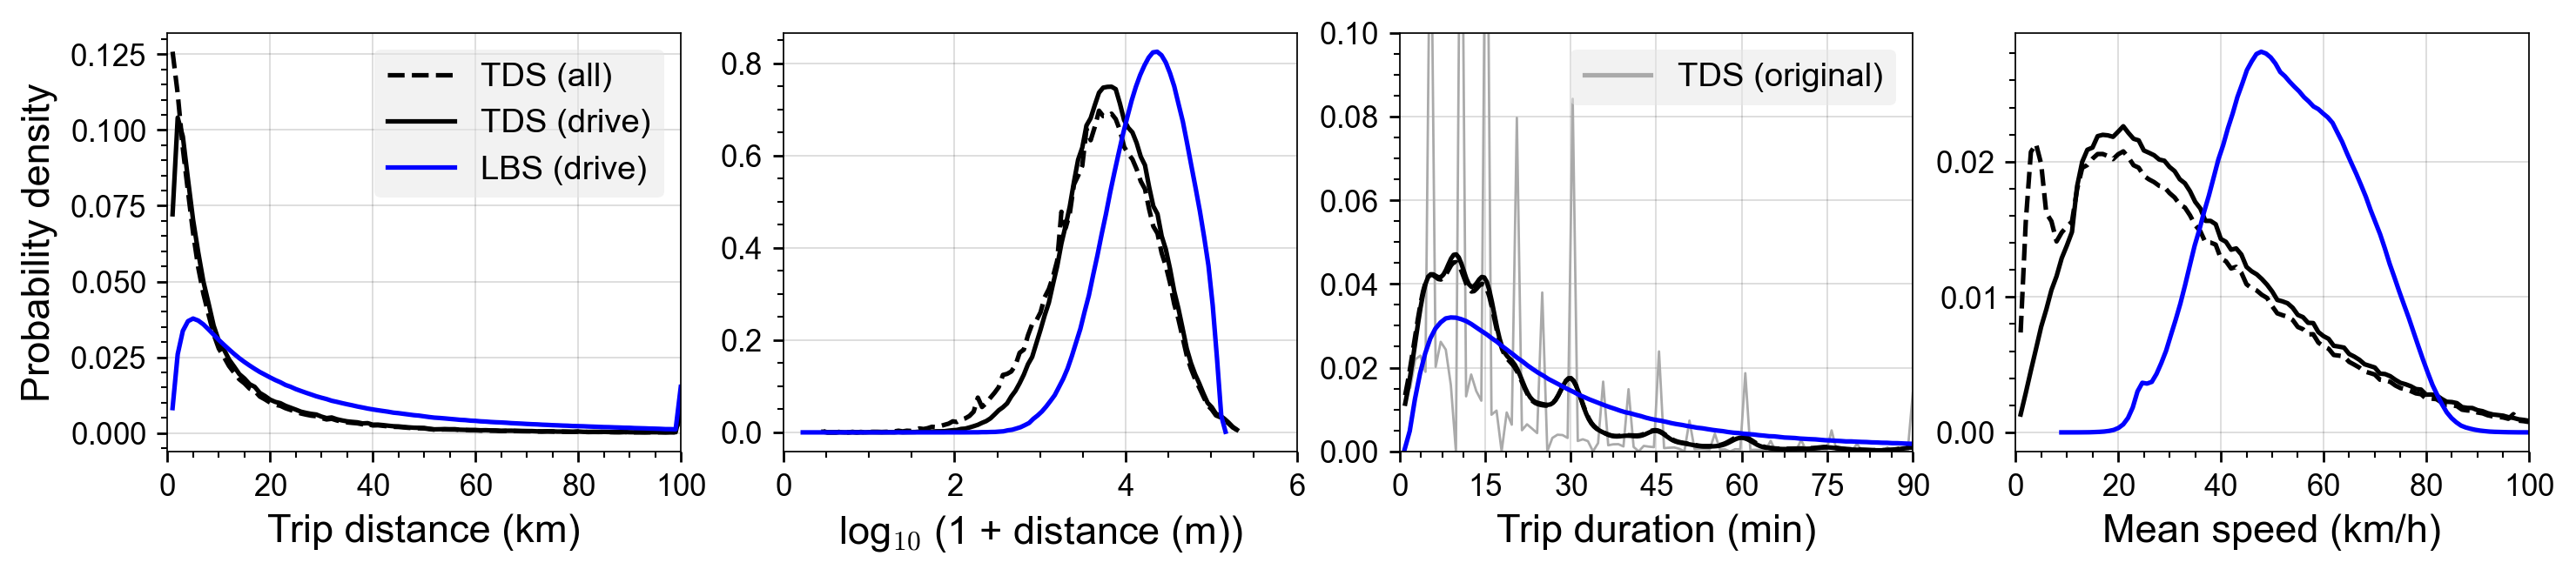

In [6]:
def fig_deterrence_distr(tds=trips, size=(14, 2.5), dpi=150):
    sg = pd.read_parquet('../data/pois/odm2.parquet', filters=[
        ('duration', '>', 0), ('purpose', '==', 'Overall')
    ], columns=['visitors', 'distance', 'duration'])
    sg.distance /= 1000; sg.duration /= 60
    sg['speed'] = sg.distance / sg.duration * 60
    def hist(x, vmax=None, bins=100, wt=None):
        y, x = np.histogram(x.clip(0, vmax), bins, density=True, weights=wt)
        return x[1:], y
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi)
    drive = tds.query('Mode == "drive"')
    ## Distance
    ax = pplot(axes[0], ylog=0, xlab='Trip distance (km)',
               ylab='Probability density', xlim=(0, 100))
    ax.plot(*hist(tds.Distance, 100), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.Distance, 100), color='k', label='TDS (drive)')
    ax.plot(*hist(sg.distance, 100), color='b', label='LBS (drive)')
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color=c, ls=ls, label=x) for x, c, ls in [
            ('TDS (all)', 'k', '--'), ('TDS (drive)', 'k', '-'), 
            ('LBS (drive)', 'b', '-')]])
    ## LogDistance
    ax = pplot(axes[1], ylog=0, xlab='log$_{10}$ (1 + distance (m))',
               ylab='Probability density', xlim=(0, 6))
    ax.plot(*hist(tds.LogDistance, 100), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.LogDistance, 100), color='k', label='TDS (drive)')
    ax.plot(*hist(np.log10(1 + sg.distance * 1000), 100), color='b', label='LBS (drive)')
    ax.set_ylabel('')
    ## Duration
    ax = pplot(axes[2], xlab='Trip duration (min)', ylim=(0, 0.1), xlim=(0, 90))
    ax.plot(*hist(tds.Duration, 90), color='#aaa', lw=0.8, label='TDS (original; all)')
    ax = sns.kdeplot(tds.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', ls='--', label='TDS (smooth; all)')
    ax = sns.kdeplot(drive.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', label='TDS (smooth; drive)')
    ax.set_ylabel('')
    ax.plot(*hist(sg.duration, 90), color='b', label='LBS (drive)')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color='#aaa', label='TDS (original)')])
    ## Speed
    ax = pplot(axes[3], xlab='Mean speed (km/h)', xlim=(0, 100))
    ax.plot(*hist(tds.Speed), color='k', ls='--', label='TDS (all)')
    ax.plot(*hist(drive.Speed), color='k', label='TDS (drive)')
    ax.plot(*hist(sg.speed), color='b', label='LBS (drive)')

x = fig_deterrence_distr(dpi=250); x # t=0:09

## 3.2. Covariates (discrete vars)

### 3.2.1. Sample sizes

In [7]:
def plot_sample_sizes(data, size=(14, 4), dpi=150):
    df = pd.concat([data[col].value_counts().rename_axis('subcat')
                    .reset_index().assign(cat=col) 
                    for col in data.select_dtypes(CAT)])
    df = df.sort_values('cat')
    df['label'] = df.cat + '__' + df.subcat
    df['color'] = df.cat.map(dict(zip(df.cat.unique(), sns.color_palette(
        'Set1', df.cat.nunique()))))
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', xlim=(-1, len(df)), 
               title='Sample size for classifications of measures', yeng=1)
    ax.bar(df.label, df['count'], color=df.color)
    ax.tick_params(which='minor', bottom=False)
    plt.xticks(rotation=90)

# plot_sample_sizes(trips, dpi=150)

## 4.1. Interactive distributions

In [8]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for measure, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 1, 6), ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                y, x = np.histogram(df[measure].clip(vmin, vmax), 
                                    bins=100, weights=df.TripWeight)
                y = (y / y.sum()).cumsum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, measure=measure))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='measure',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

plot_distr_vars()

# SHAP analysis

## 4.2. Select regression model

### Define models, datasets & metrics

In [22]:
metrics = D(r2=r2_score, mae=mean_absolute_error, mse=mean_squared_error)

In [10]:
class Dataset:
    def __init__(self, target, test_ratio, n=None, 
                 wide=True, factors=[], data=trips, seed=1234):
        rng = D(LogDistance=(2, 5), Duration=(0, 90))[target]
        if isinstance(n, int):
            data = data.sample(n, random_state=seed)
        self.X = data.select_dtypes(CAT)
        if type(factors) in [list, set, tuple] and len(factors) > 0:
            self.X = self.X[list(factors)]
        if wide:
            self.X = pd.get_dummies(self.X, prefix_sep='__')
        self.y = normalize(data[target], *rng)
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(
                self.X, self.y, test_size=test_ratio, random_state=seed)
        wts = data['TripWeight'].rename('weight')
        self.wtrain = wts.loc[self.Xtrain.index]
        self.wtest = wts.loc[self.Xtest.index]

ds_full = {x: Dataset(x, 0.3) for x in ['LogDistance', 'Duration']}
ds_mini = {x: Dataset(x, 0.3, n=10_000) for x in ['LogDistance', 'Duration']}

In [21]:
test_models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge', BayesianRidge(max_iter=1000), D(
        alpha_1=[.5e-6, 1e-6, 2e-6],
        alpha_2=[.5e-6, 1e-6, 2e-6],
        lambda_1=[.5e-6, 1e-6, 2e-6],
        lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ## Kernel models
    ('Kernel Ridge', KernelRidge(), D(
        alpha=[0.1, 0.5, 1.0, 2.0],
        degree=[2, 3, 4, 5],
        kernel=['linear', 'poly', 'rbf'],
    )),
    ('SVR', SVR(max_iter=10000), D(
        C=[0.5, 1.0, 1.5],
        degree=[2, 3, 4, 5],
        gamma=['scale', 'auto'],
        kernel=['linear', 'poly', 'rbf'],
    )),
    ## Decision tree models
    ('Light Gradient Boost', LGBMRegressor(n_jobs=12), D(
        boosting_type=['gbdt', 'rf'],
        learning_rate=[0.05, 0.1, 0.5],
        max_depth=[10, 20, 30, 40],
        n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost', XGBRegressor(n_jobs=12), D(
        booster=['gbtree', 'gblinear'],
        learning_rate=[0.05, 0.1, 0.5],
        max_depth=[10, 20, 30, 40],
        n_estimators=[100, 200, 500, 750, 1000],
    )),
)

### Cross validate models on mini dataset

In [36]:
def compare_reg_mini(models, datasets, metrics=metrics, overwrite=False):
    outpath = Path(f'../data/result/model_comparison_mini.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    pbar = tqdm(list(it.product(models, datasets.items())))
    for (name, model, params), (target, ds) in pbar:
        pbar.set_description(f'{target}: {name}')
        cv = GridSearchCV(model, params, cv=5, n_jobs=6)
        cv.fit(ds.Xtrain, ds.ytrain)
        runtime = cv.cv_results_['mean_fit_time'].mean()
        row = D(target=target, model=name, cv=cv, runtime=runtime)
        best = cv.best_estimator_
        ypred = best.predict(ds.Xtest)
        for metric, func in metrics.items():
            row[metric] = func(ds.ytest, ypred)
        res.append(row)
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

res_mini = compare_reg_mini(test_models, ds_mini, overwrite=0).disp() # t=10:44

14 rows x 7 cols; Memory: 0.0 MiB


target              model  ...        mae        mse
      <object>           <object>  ...  <float64>  <float64>
0  LogDistance  Linear Regression  ...    0.13501   0.029829

[2 rows x 7 columns]

### Compare models on main dataset

In [41]:
def compare_reg_full(cv_df, datasets, metrics=metrics, overwrite=False):
    outpath = Path(f'../data/result/model_comparison_full.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    res = []
    pbar = tqdm(list(cv_df.iterrows()))
    for _, r in pbar:
        pbar.set_description(f'{r.target}: {r.model}')
        ds = datasets[r.target]
        model = r.cv.best_estimator_
        row = D(target=r.target, model=r.model)
        ypred = model.predict(ds.X)
        for metric, func in metrics.items():
            row[metric] = func(ds.y, ypred)
        res.append(row)
    res = Pdf(res)
    res.to_csv(mkfile(outpath), index=False)
    return res

res_full = compare_reg_full(res_mini, ds_full, overwrite=0).disp() # t=9:30

14 rows x 5 cols; Memory: 0.0 MiB


target              model         r2        mae        mse
      <object>           <object>  <float64>  <float64>  <float64>
0  LogDistance  Linear Regression   0.318894   0.130958   0.028037

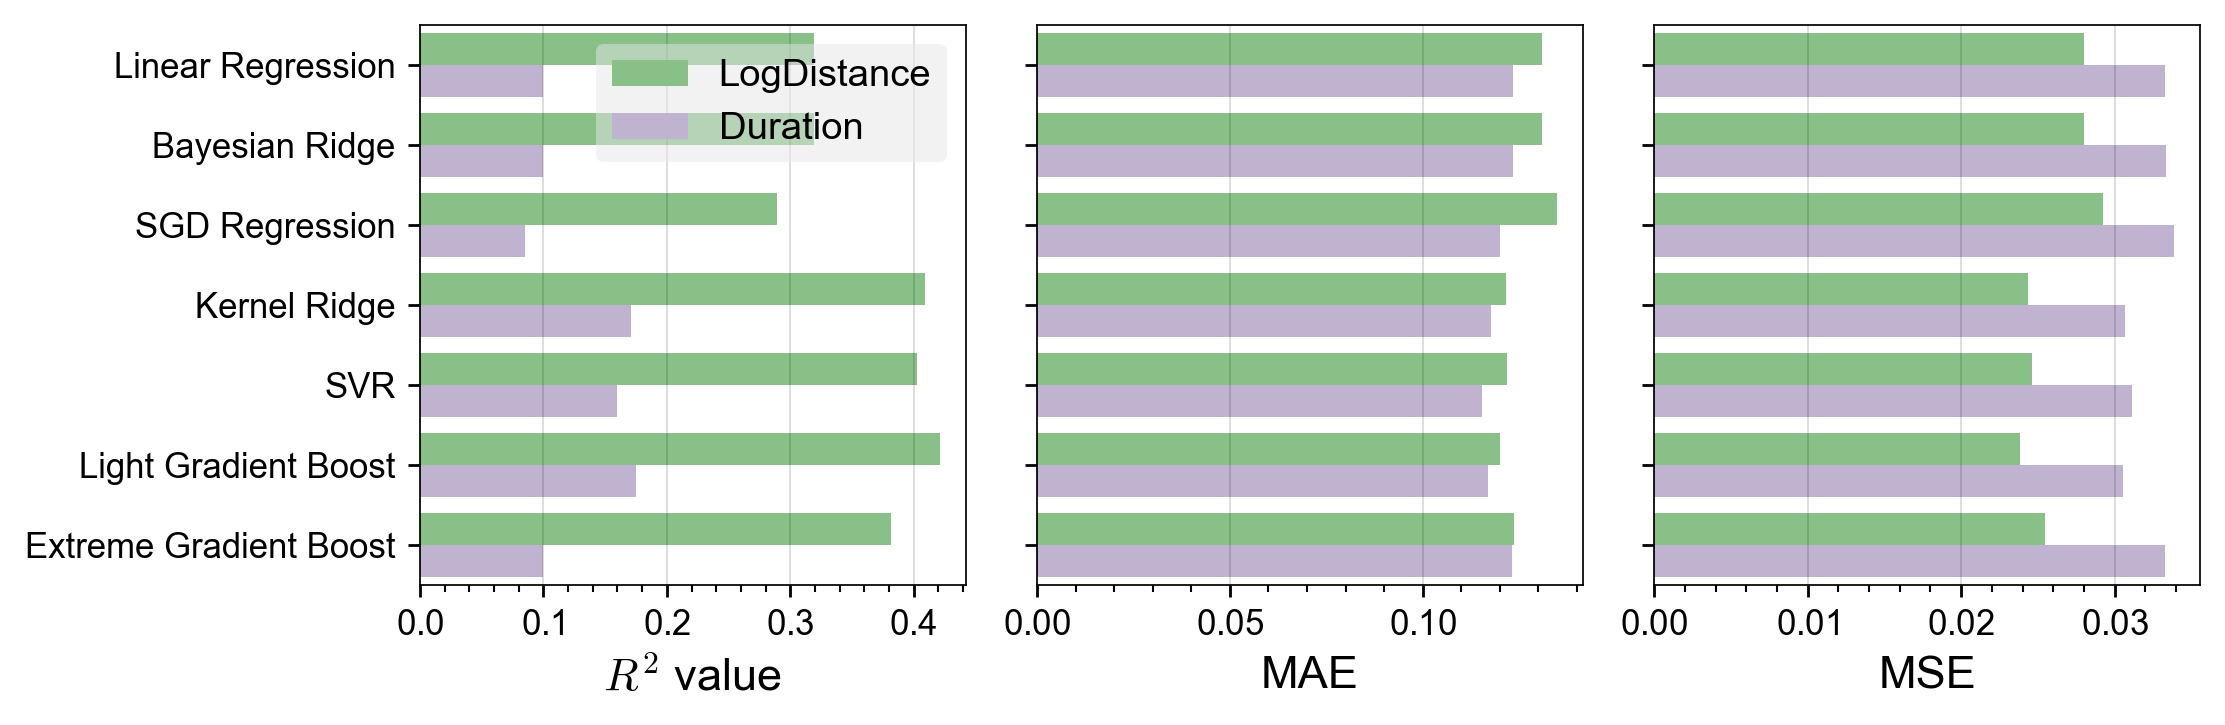

In [43]:
def fig_compare_models(res, size=(9, 3), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    for i, (metric, label) in enumerate([
            ('r2', '$R^2$ value'), ('mae', 'MAE'), ('mse', 'MSE')]):
        ax = pplot(axes[i], xlab=label, yminor=0)
        sns.barplot(res, ax=ax, x=metric, y='model', hue='target', palette='Accent')
        ax.set_ylabel('')
        if i == 0:
            ax.legend_.set_title(None)
        if i > 0:
            ax.legend_.remove()
            ax.set_yticklabels([])
    plt.tight_layout()
    
# fig_compare_models(res_mini, dpi=250)
fig_compare_models(res_full, dpi=250)

### Finalize the best model

In [45]:
reg = {r.target: r.cv.best_estimator_ for _, r in res_mini.query(
    'model=="Light Gradient Boost"').iterrows()}
reg['Duration']

LGBMRegressor(learning_rate=0.05, max_depth=20, n_jobs=12)

## Feature importances

In [ ]:
def f():
    pass



In [59]:
res = Pdf(D(factor=best_model.feature_name_, imp=normalize(best_model.feature_importances_)))
res['feature'], res['level'] = list(zip(*res.factor.str.split('__')))
res['color'] = res.feature.astype(CAT).cat.codes.map(dict(enumerate(
    sns.color_palette('tab20', res.feature.nunique())))).apply(mpl.colors.to_hex)
res = res.sort_values('imp', ascending=0).disp()

86 rows x 5 cols; Memory: 0.0 MiB


factor        imp   feature     level     color
         <object>  <float64>  <object>  <object>  <object>
64  UrbanO__rural        1.0    UrbanO     rural   #2ca02c

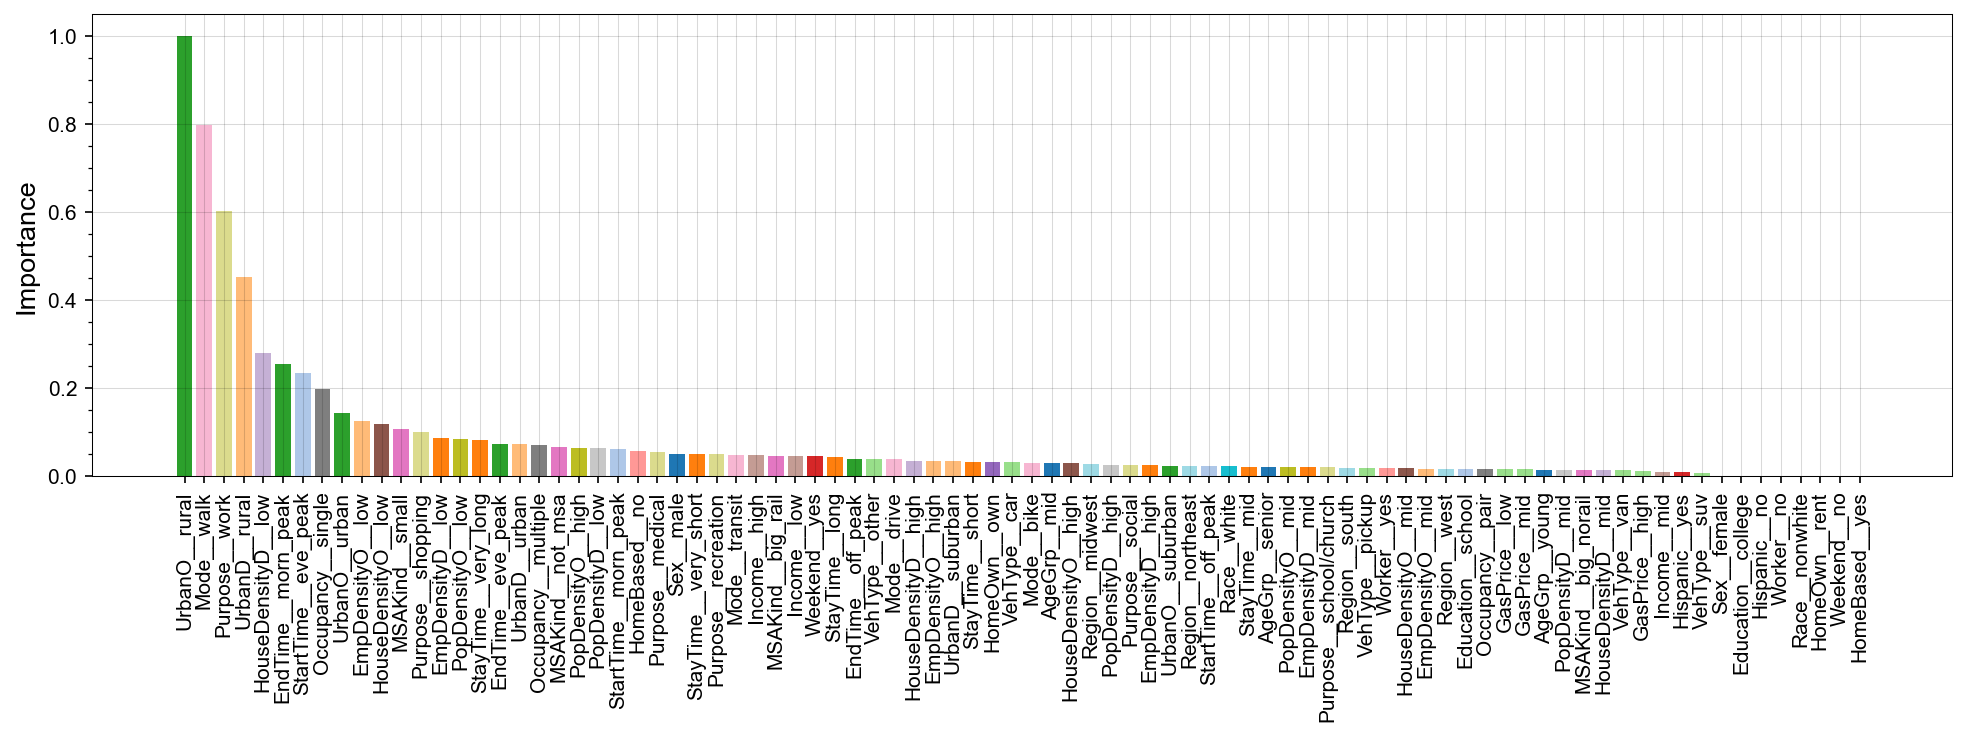

In [62]:
ax = pplot(size=(16, 4), ylab='Importance', xminor=False)
ax.bar(res.factor, res.imp, color=res.color)
plt.xticks(rotation=90);

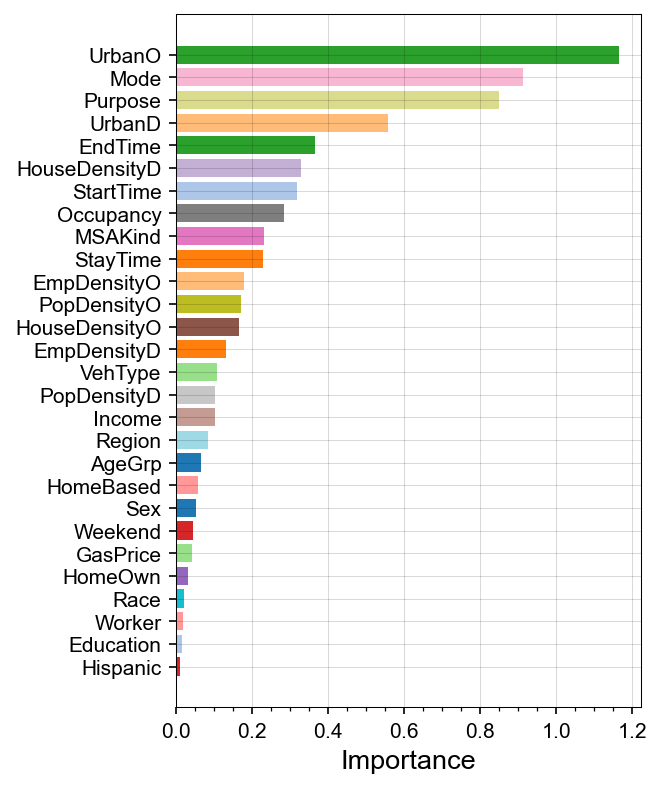

In [89]:
ax = pplot(size=(4, 6), xlab='Importance', yminor=False)
res2 = res.groupby(['feature', 'color'])['imp'].sum().sort_values().reset_index()
ax.barh(res2.feature, res2.imp, color=res2.color);

## 4.3. Compute SHAP

In [13]:
def get_shap(model, vars_=('LogDistance', 'Duration'), n_datasets=20,
             test_ratio=0.3, wtd=True, data=trips, seed=1234, overwrite=False):
    outpath = Path('../data/result/shap_models.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    np.random.seed(seed)
    seeds = np.random.randint(0, 1e4, n_datasets)
    for var, seed in tqdm(list(it.product(vars_, seeds))):
        ds = Dataset(var, test_ratio, seed=seed)
        model.fit(ds.Xtrain, ds.ytrain, ds.wtrain if wtd else None)
        explainer = shap.TreeExplainer(model, seed=seed)
        shaps = np.abs(explainer(ds.Xtest).values).mean(0)
        df = Pdf(D(feature=ds.X.columns, shap=shaps))
        res.append(df.assign(var=var, seed=seed))
    res = pd.concat(res).reset_index(drop=1)
    res.to_parquet(mkfile(outpath))
    return res

model = LGBMRegressor(n_estimators=500, learning_rate=0.05, force_row_wise=False, n_jobs=-1, verbose=-1)
shaps = get_shap(model).disp() # t=2:06:41

1,120 rows x 4 cols; Memory: 0.2 MiB


feature       shap          var     seed
    <object>  <float64>     <object>  <int64>
0  HomeBased   0.028069  LogDistance     8915

## 4.4. Finalize relevant features

/home/umni2/a/umnilab/users/verma99/anaconda3/envs/mk11/lib/python3.11/site-packages/matplotlib/ticker.py:2937: RuntimeWarning:

invalid value encountered in log10



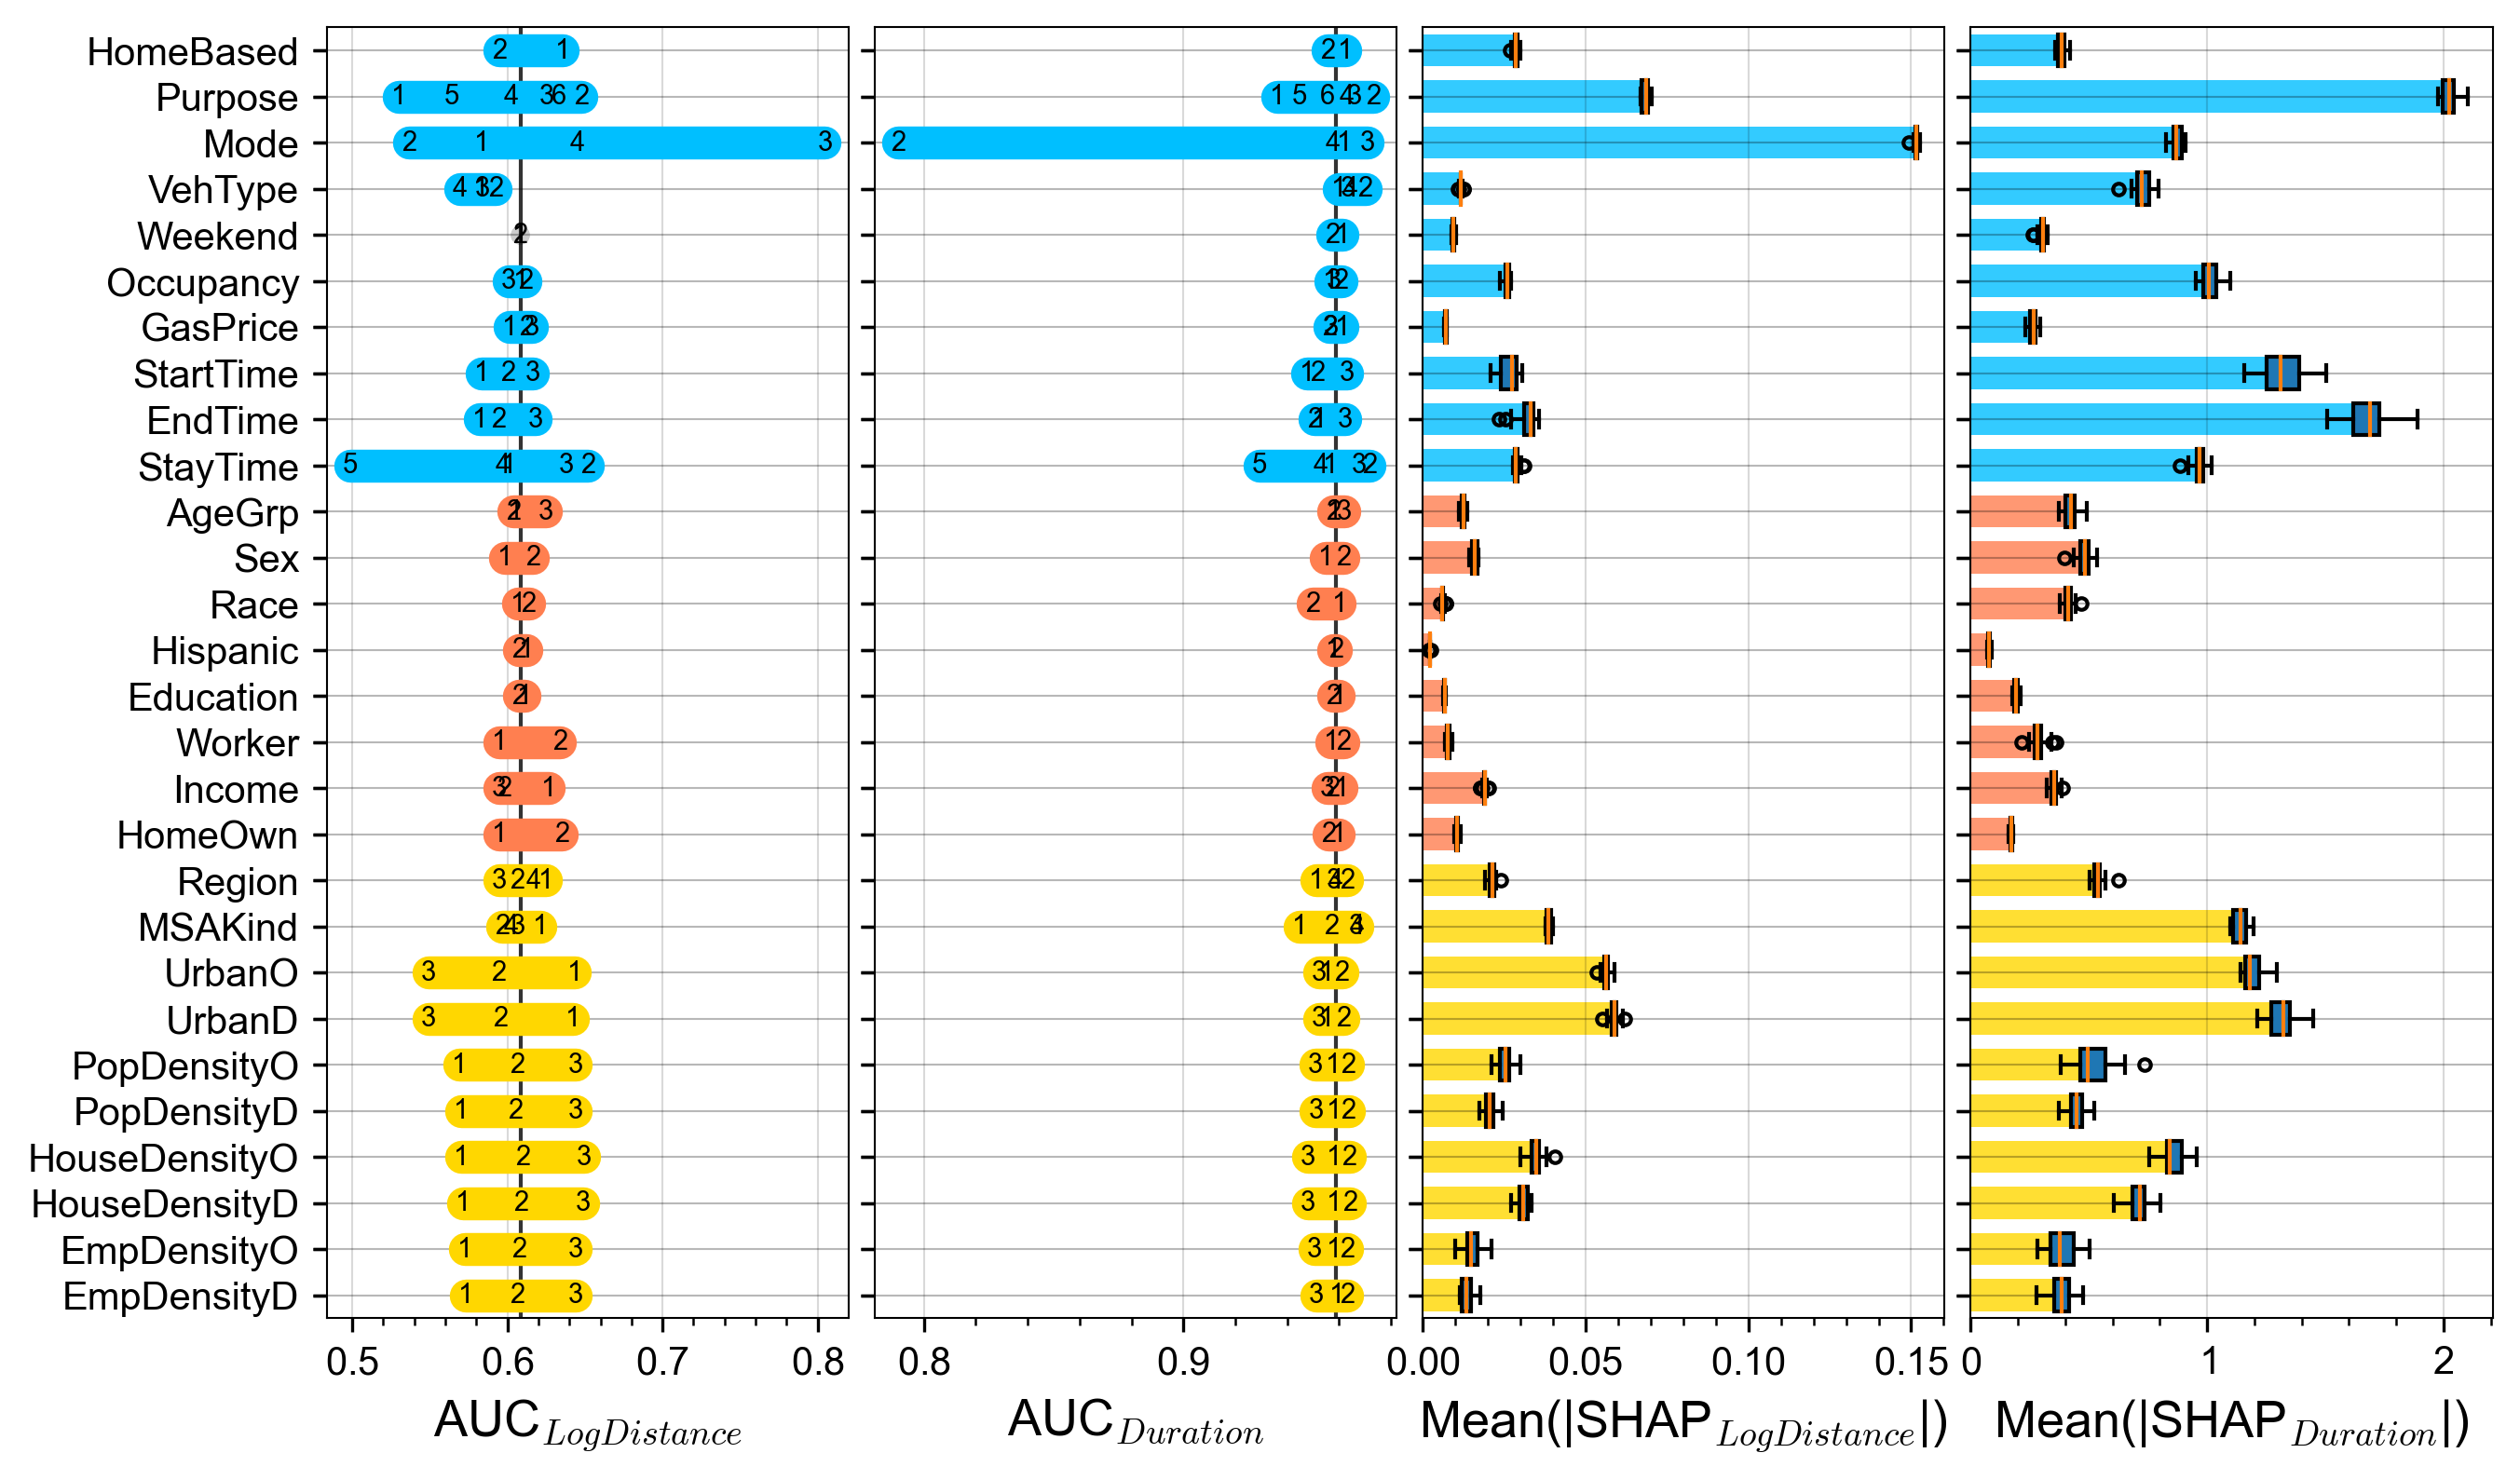

In [97]:
def fig_feature_selection(data, shaps=shaps, grps=feature_grps, win=5,
                          size=(10, 6), dpi=150):
    pts = [] # table for distributional summary value for each factor level
    features = data.select_dtypes(CAT).columns
    mean_auc = {}
    for var, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 2, 5)]:
        def auc(df): # area under curve of CDF
            y, x = np.histogram(df[var].clip(vmin, vmax + win), 
                                bins=100, weights=df.TripWeight, density=1)
            y = Series(y[::-1]).rolling(win).median()[::-1].fillna(0)
            F = (y / y.sum()).cumsum() # CDF
            return (F * x[:-1]).sum() / x[:-1].sum() # area under curve of CDF
        mean_auc[var] = auc(data)
        for feat in features: # for each feature
            for j, (cat, df) in enumerate(data.groupby(feat)): # for each level
                if feat == 'VehType' and cat == 'other': continue
                pts.append(D(var=var, feature=feat, cat_id=j, cat=cat, value=auc(df)))
    pts = Pdf(pts)
    shaps = (shaps.groupby(['var', 'feature'])['shap'].agg(list).reset_index())
    res = (pts.groupby(['var', 'feature'])['value'].agg(['min', 'max'])
           .rename(columns='auc_{}'.format).reset_index()
           .merge(shaps, on=('var', 'feature')))
    res = res.merge(grps, on='feature')
    res.feature = pd.Categorical(res.feature, categories=features)
    res['color'] = res.group.map(D(Trip='deepskyblue', SES='coral', OD='gold'))
    res['pos'] = len(features) - res.feature.cat.codes - 1
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi, sharey=True)
    for i, (var, vmax) in enumerate([('LogDistance', 0.3), ('Duration', 0.2)]):
        ## AUC
        ax = pplot(axes[i], xlab='AUC$_{%s}$' % var, xlog=0)
        df = pts.merge(res, on=('var', 'feature')).query(f'var=="{var}"')
        ax.scatter(df.value, df.pos, s=15, color='#ccc')
        ax.axvline(mean_auc[var], ls='-', color='k', lw=1, alpha=0.8)
        for _, r in df.iterrows():
            ax.text(r.value, r.pos, str(r.cat_id + 1), fontsize=7,
                    color='k', ha='center', va='center')
        df = res[res['var'] == var].sort_values('feature')
        for _, r in df.iterrows():
            ax.add_artist(mpl.lines.Line2D(
                [r.auc_min, r.auc_max], [r.pos] * 2, lw=8.5,
                alpha=1, color=r.color, solid_capstyle='round'))
        ## SHAP values
        ax = pplot(axes[i + 2], xlab='Mean(|SHAP$_{%s}$|)' % var)
        ax.barh(df.pos, df.shap.apply(np.median), tick_label=df.feature, 
                color=df.color, alpha=0.8, height=0.7)
        ax.boxplot(df.shap, vert=False, positions=df.pos, widths=0.7, patch_artist=True, 
                   labels=df.feature, flierprops=D(markersize=3), meanprops=D(markersize=8))
    for i, ax in enumerate(axes):
        ax.set_ylim(-0.5, len(features) - 0.5)
        ax.tick_params(which='minor', left=False)
    plt.subplots_adjust(wspace=0.05)

x = fig_feature_selection(trips, shaps, dpi=300); x # t=0:05

## 4.5. Important distributions

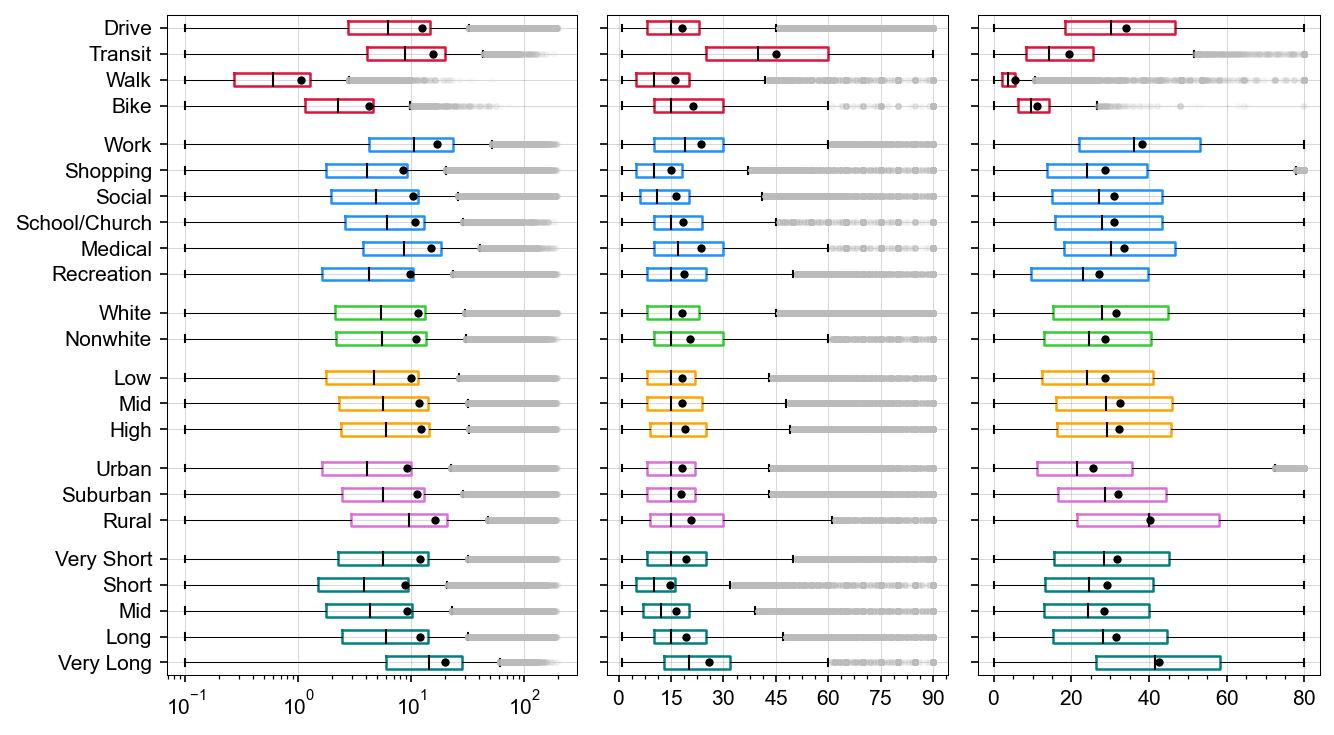

In [16]:
def plot_distr_box(data=trips, size=(9, 5), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi, 
                             gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    cols = D(Mode='crimson', Purpose='dodgerblue', Race='limegreen',
             Income='orange', UrbanO='orchid', StayTime='teal')
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, var, rng, title in [(0, 'Distance', (0.1, 1000), 'Trip length (km)'),
                               (1, 'Duration', (0, 90), 'Trip duration (min)'),
                               (2, 'Speed', (0, 80), 'Speed (km/h)')]:
        df = Pdf(sum([[D(col=col, cat=x[0].title().replace('_', ' '),
                         vals=x[1].values, pos=i / 2, n=ticker(len(x[1]))) 
                       for x in data.groupby(col)[var]]
                      for i, col in enumerate(cols.keys())], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(cols)
        ax = pplot(axes[j], xlog=var == 'Distance')
        x = ax.boxplot(df.vals, positions=df.pos + df.index,
                       labels=df.cat,# + ' (' + df.n + ')',
                       vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2),
                       flierprops=D(markersize=2, markeredgecolor='#bbb1'),
                       showmeans=True, meanline=False, meanprops=D(
                           marker='o', markersize=4, 
                           markeredgecolor='none', markerfacecolor='k'),
                       medianprops=D(color='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if var == 'Duration': ax.set_xticks(np.arange(0, 91, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()

x = plot_distr_box(dpi=150); x

# 5. OD: Density & urbanity

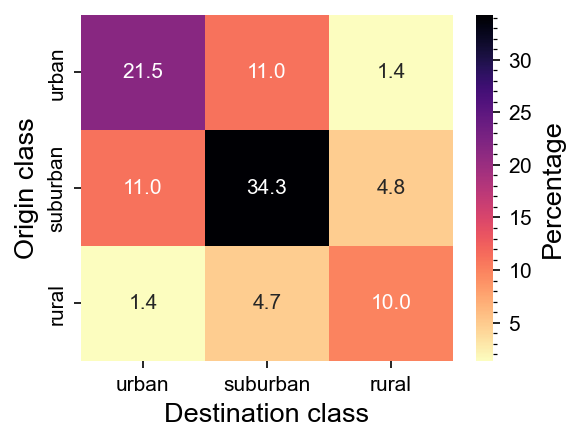

In [16]:
ax = pplot(size=(4, 3), dpi=150)
sns.heatmap(trips[['UrbanO', 'UrbanD']].value_counts()
            .pipe(lambda x: x / x.sum() * 100).reset_index()
            .pivot_table('count', 'UrbanO', 'UrbanD'),
            ax=ax, cmap='magma_r', annot=True, fmt='.1f',
            cbar_kws=D(label='Percentage'))
ax.minorticks_off(); ax.grid(False)
ax = pplot(ax, xlab='Destination class', ylab='Origin class')

In [17]:
trips[feature_grps.query('group=="OD"')['feature']].value_counts()

Region  MSAKind     UrbanO    UrbanD    PopDensityO  PopDensityD  HouseDensityO  HouseDensityD  EmpDensityO  EmpDensityD
west    big_rail    urban     urban     high         high         high           high           high         high           16583
south   big_norail  suburban  suburban  mid          mid          mid            mid            mid          mid            16106
        not_msa     rural     rural     low          low          low            low            low          low            14522
        small       suburban  suburban  low          low          low            low            low          low            14333
                                        mid          mid          mid            mid            mid          mid            12989
                                                                                                                            ...  
        big_rail    suburban  suburban  high         high         low            mid            mid

# 6. SES

In [81]:
class Dataset:
    def __init__(self, var, test_ratio, n=None, 
                 wide=False, factors=[], data=trips, seed=1234):
        if isinstance(n, int):
            data = data.sample(n, random_state=seed)
        self.X = data.select_dtypes(CAT)
        if type(factors) in [list, set, tuple] and len(factors) > 0:
            self.X = self.X[list(factors)]
        if wide:
            self.X = pd.get_dummies(self.X, prefix_sep='__')
        self.y = data[var]
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = \
            skl.model_selection.train_test_split(
                self.X, self.y, test_size=test_ratio, random_state=seed)
        wts = data['TripWeight'].rename('weight')
        self.wtrain = wts.loc[self.Xtrain.index]
        self.wtest = wts.loc[self.Xtest.index]
    
ses_cols = list(trips[feature_grps.query('group=="SES"')['feature']].select_dtypes(CAT).columns)
dsSES = Dataset('Distance', 0.25, n=100_000, factors=ses_cols, wide=False)

In [80]:
best_model.fit(dsSES.Xtrain, dsSES.ytrain)
skl.metrics.r2_score(dsSES.ytest, best_model.predict(dsSES.Xtest))

0.011150865894630546

In [ ]:
bes